In [1]:
import os
project_base = '/opt/ml/input/data'
train_img_dir = os.path.join(project_base, 'train', 'images')
test_img_dir = os.path.join(project_base, 'test', 'images')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv(os.path.join(project_base, 'train', 'train.csv'))

In [3]:
train_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


# 1. Dataset Analysis

## 1.1 Dataset Statistics
 - 전체 이미지에 대한 이미지의 개수, 사이즈, RGB 값의 평균과 표준편차를 계산

In [4]:
from glob import glob
from PIL import Image
from tqdm import tqdm

new_train_dict = dict(id=[], gender=[], race=[], age=[], img_path=[])

for idx, path in enumerate(train_df['path']):
    img_path = os.path.join(train_img_dir, path, '*')
    imgs = glob(img_path)
    
    new_train_dict['id'].extend([train_df['id'][idx]]*len(imgs))
    new_train_dict['gender'].extend([train_df['gender'][idx]]*len(imgs))
    new_train_dict['race'].extend([train_df['race'][idx]]*len(imgs))
    new_train_dict['age'].extend([train_df['age'][idx]]*len(imgs))
    new_train_dict['img_path'].extend(imgs)
    
new_train_df = pd.DataFrame(new_train_dict)

In [5]:
def get_img_stats(image_paths):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        image_paths: 학습 데이터셋 이미지 경로 

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for image_path in tqdm(image_paths):
        img = np.array(Image.open(image_path))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
        
    return img_info

In [7]:
img_info = get_img_stats(new_train_df['img_path'])

print(f'Total number of people is {len(train_df)}')
print(f'Total number of imgage is {len(new_train_df)}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {np.mean(img_info["heights"])}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {np.mean(img_info["widths"])}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

100%|██████████| 18900/18900 [06:26<00:00, 48.88it/s]


Total number of people is 2700
Total number of imgage is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512.0
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384.0
RGB Mean: [0.56019358 0.52410121 0.501457  ]
RGB Standard Deviation: [0.23318603 0.24300033 0.24567522]


### 1.2 Metadata Analysis
 - `train.csv`에 저장되어있는 MetaData 분석.

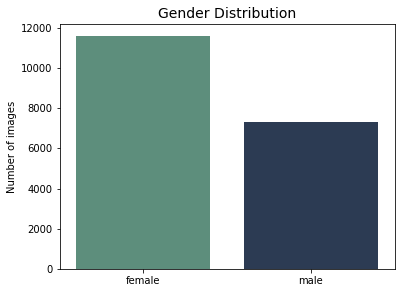

gender
female    11606
male       7294
dtype: int64

In [8]:
import seaborn as sns
plt.figure(figsize=(6, 4.5)) 
ax = sns.countplot(x = 'gender', data = new_train_df, palette=["#55967e", "#263959"])

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('Gender Distribution',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')
plt.show()

new_train_df.value_counts("gender")

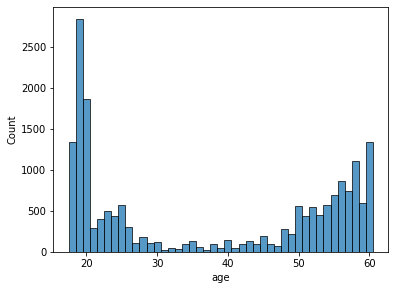

In [9]:
plt.figure(figsize=(6, 4.5))
ax = sns.histplot(data=new_train_df, x='age', discrete=True)

## 2. Image Analysis
- 전체 데이터셋의 분포를 확인했다면, 이미지 한장 한장에 대해서 좀 더 알아봅시다. 클래스에 따라 이미지는 어떤 분포를 가지는지, 이미지를 시각화하여 직접 관찰해보자.

### 2.1 Class Histogram
- 예시 파일을 하나 선택하여 마스크의 유무에 따른 이미지 픽셀값의 분포를 확인해봅시다.

Text(0.5, 1.0, 'Class Grayscale Histogram Plot')

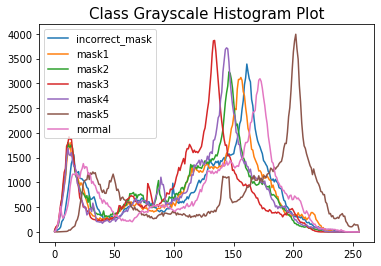

In [10]:
img_path = train_df.iloc[500].path
paths = sorted(glob(os.path.join(train_img_dir, img_path, '*')))

plt.figure()
legend = []
for path in paths:
    img = np.array(Image.open(path).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)
    legend.append(os.path.basename(path).split('.')[0])
    
plt.legend(legend)
plt.title('Class Grayscale Histogram Plot', fontsize=15)

Text(0.5, 1.0, 'Class Grayscale Histogram Plot')

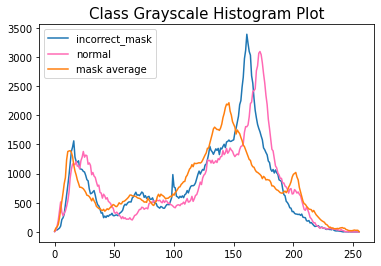

In [11]:
plt.figure()

img = np.array(Image.open(paths[0]).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(paths[6]).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(paths[i]).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)

### 2.2 Image Visualization
- 이 파트에서는 이미지를 직접 시각화하여 눈으로 관찰해봅시다. 사람마다 총 7장의 사진이 존재합니다. (마스크 정상 착용 5장, 미착용 1장, 이상하게 착용 1장).
- 한 사람의 데이터를 시각화해봅시다.

In [ ]:
count = 0

In [ ]:
plt.figure(figsize=(15,10))
imgs = [np.array(Image.open(path)) for path in new_train_df['img_path'][count: count+7]]

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 10))
for i in range(7):
    axes[i//3][i%3].imshow(imgs[i])
    axes[i//3][i%3].set_title(os.path.basename(new_train_df['img_path'][count+i]).split('.')[0], color='r')

plt.tight_layout()
count += 7